# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [ ]:
# libraries and packages import
import os
import shutil
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns

In [51]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


# Data download and preprocess

Be careful if you are running this on COLAB or locally.
Due to some bugs, datasets creation is different.
Change the lower COLAB bool to True if running on COLAB.

In [52]:
COLAB = False  # if True, run on Google Colab, else on local repository


In [ ]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
N_EPOCHS = 30
VERBOSE = True # True for debug prints


IF RUNNING ON COLAB

In [ ]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
# Only working on Colab (and locally if tfds.load works correctly)

def load_from_tfds():
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        shuffle_files=True,
        as_supervised=True,  # returns (image, label) pairs
        with_info=True,
    )

    # labels are plant families
    class_names = ds_info.features['label'].names
    families = sorted({n.split('___')[0] for n in class_names})
    split_labels = families
    family_map = tf.constant([families.index(n.split('___')[0]) for n in class_names], dtype=tf.int32)

    # returns label as one-hot
    def to_ohe(img, lbl):
      idx = tf.gather(family_map, lbl)
      return img, tf.one_hot(idx, len(split_labels))

    ds_train = ds_train.map(to_ohe)
    ds_val   = ds_val.map(to_ohe)
    ds_test  = ds_test.map(to_ohe)

    print(split_labels)

    return ds_train, ds_val, ds_test, split_labels, ds_info


In [ ]:
# if on colab, define preprocess.py (this is the same function defined in preprocessing.py)
if COLAB:
    def preprocess(image, label, image_size=(128, 128)):
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label


IF RUNNING ON LOCAL REPOSITORY

If you are working on a local repository, first of all you need to clone the dataset into a local folder. 
Execute the command "git clone https://github.com/spMohanty/PlantVillage-Dataset" in the terminal while you are in a known path. Make sure to set the base_path variable below to point to that cloned folder. 

Only run the git clone command if you haven’t already downloaded the dataset to your PC.

In [ ]:
# Define local path to generate split
if not COLAB:
    from pathlib import Path
    from preprocessing import preprocess

    base_path = Path(r"D:\progetto-daml") #Change according to the path where PlantVillage-Dataset is cloned. A different path than progetto-daml is suggested.
    base_path = base_path / "PlantVillage-Dataset"
    #base_path = Path(r"/home/luchino/Desktop/ProgettoML/Dataset")

    OUTPUT_ROOT = base_path / "by_family"
    DS_DIR = OUTPUT_ROOT / "train"


In [ ]:
#ONLY RUN FIRST TIME, AFTER DATASET CLONING

SOURCE_DIR = base_path / "raw/color"
TRAIN_FRAC = 0.8 #change fractions
VAL_FRAC = 0.1
TEST_FRAC = 0.1

# Create output folders
for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

# Collect folders name and map into family name folders
disease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])
families = sorted({d.name.split("___")[0] for d in disease_folders})

for split in ("train","val","test"):
    for fam in families:
        (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)

# Splits files into train, validation and test for each family
for disease_dir in disease_folders:
    fam = disease_dir.name.split("___")[0]
    images = list(disease_dir.glob("*.*"))  # all image files
    random.shuffle(images)

    n = len(images)
    n_train = int(n * TRAIN_FRAC)
    n_val   = int(n * VAL_FRAC)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    # Put the datasets into the local folders
    for img in train_imgs:
        shutil.copy(img, OUTPUT_ROOT/"train"/fam/img.name)
    for img in val_imgs:
        shutil.copy(img, OUTPUT_ROOT/"val"/fam/img.name)
    for img in test_imgs:
        shutil.copy(img, OUTPUT_ROOT/"test"/fam/img.name)

print("Datasets paths are:\n",
    OUTPUT_ROOT / "train\n", 
    OUTPUT_ROOT / "val\n", 
    OUTPUT_ROOT / "test\n")


In [ ]:
# read split data into train, validation e test sets
def prepare_local_dataset():
    split_labels = sorted([p.name for p in (OUTPUT_ROOT/"train").iterdir() if p.is_dir()]) #folders names

    ds_train_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        label_mode='categorical',
    )

    ds_val_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False,
    )

    ds_test_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False,
    )

    return ds_train_ohe, ds_val_ohe, ds_test_ohe, split_labels


# Training


In [58]:
# cnn layers
def simple_cnn(input_shape, num_classes, l2_coef=1e-3):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_coef), input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_coef)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        #Conv2D(128, (3, 3), padding='same'),
        #BatchNormalization(),
        #Activation('relu'),
        #MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        #Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_coef))
    ])
    return model


In [ ]:
# preprocess and batch datasets. Useful objects are defined
def model_preprocess(COLAB):
    if COLAB:
        ds_train, ds_val, ds_test, split_labels, ds_info = load_from_tfds()
        ds_train = ds_train.shuffle(buffer_size=5000) # only shuffle train set
        ds_train = ds_train.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation
        ds_val = ds_val.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        ds_test = ds_test.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        ds_train, ds_val, ds_test, split_labels = prepare_local_dataset()

    num_classes = len(split_labels)
    checkpoint = "best_model_14_families_focal.h5"

    return ds_train, ds_val, ds_test, split_labels, num_classes, checkpoint



In [60]:
# model compilation
def model_train(num_classes):
    model = simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes)

    optimizer = Adam(learning_rate=0.001)
    # optimizer = SGD(learning_rate=0.05, momentum=0.9)
    model.compile(
        optimizer=optimizer,
        loss=CategoricalFocalCrossentropy(alpha = 0.25, gamma = 2),
        metrics=['accuracy']
    )

    model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
    model.summary()
    return model


In [61]:
# program running (all the functions above are executed)
train_set, val_set, test_set, split_labels, num_classes, checkpoint_file = model_preprocess(COLAB)


Found 43429 files belonging to 14 classes.
Found 5417 files belonging to 14 classes.
Found 5459 files belonging to 14 classes.


In [ ]:
# debug prints: labels, number of labels, checkpoint file name
if VERBOSE:
    print(split_labels)
    print(len(split_labels))
    print(checkpoint_file)

['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
14
best_model_14_families_focal.h5


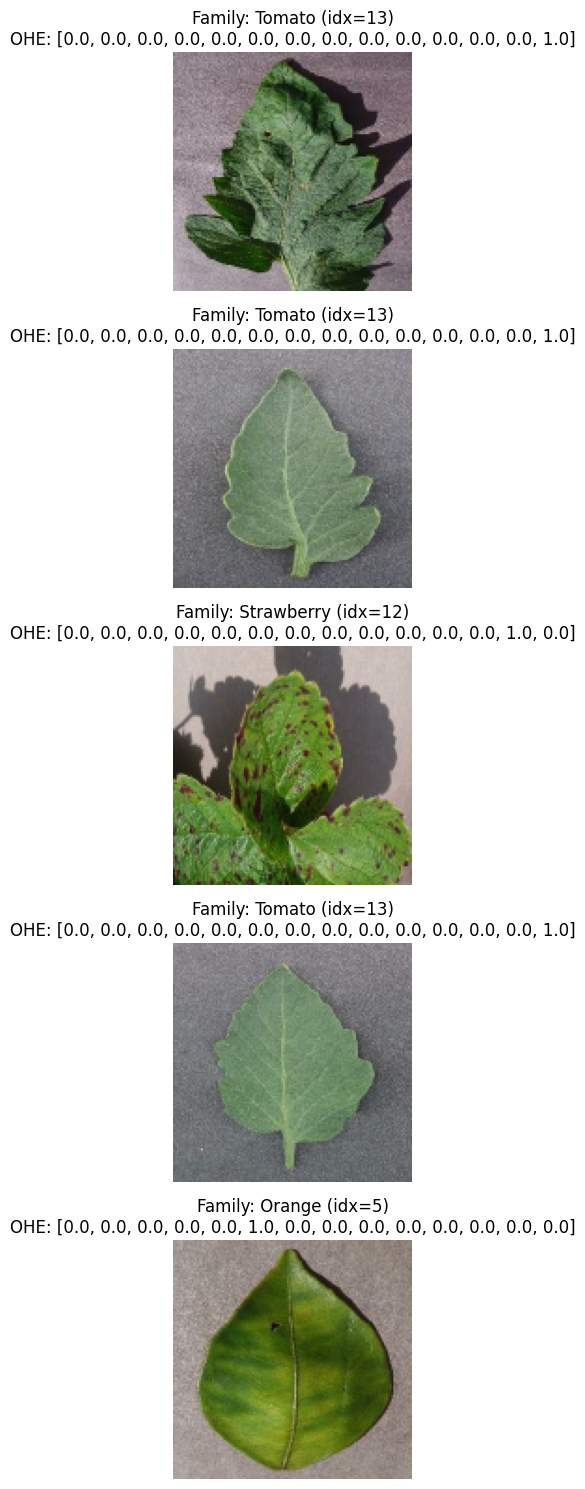

In [ ]:
# debug print for families - ohe labels cross check
def display_samples_with_labels_ohe(dataset, num_samples=5):
    plt.figure(figsize=(6, 3 * num_samples))
    for i, (img, label_ohe) in enumerate(dataset.unbatch().take(num_samples)):
        # Tensors are converted into numpy arrays
        img_np   = img.numpy().astype("uint8")
        ohe_vec  = label_ohe.numpy()                     # one-hot vector
        fam_idx  = int(tf.argmax(label_ohe).numpy())     # family index
        fam_name = split_labels[fam_idx]

        ax = plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Family: {fam_name} (idx={fam_idx})\nOHE: {ohe_vec.tolist()}")
    plt.tight_layout()
    plt.show()

# example on train batch
if VERBOSE:
    display_samples_with_labels_ohe(train_set, num_samples=5)


In [ ]:
# counting number of images per class
from collections import Counter

if VERBOSE:
    counts = Counter()
    
    for _, batch_labels in train_set:
        idxs = np.argmax(batch_labels.numpy(), axis=1)
        counts.update(idxs)
    
    print(f"Number of classes: {len(split_labels)}")
    print("Number of images per class:")
    for idx in range(len(split_labels)):
        print(f"{split_labels[idx]}: {counts[idx]} images")


Number of classes: 14
Number of images per class:
Apple: 2536 images
Blueberry: 1201 images
Cherry: 1524 images
Corn: 3080 images
Grape: 3248 images
Orange: 4405 images
Peach: 2125 images
Pepper,_bell: 1979 images
Potato: 1721 images
Raspberry: 296 images
Soybean: 4072 images
Squash: 1468 images
Strawberry: 1251 images
Tomato: 14523 images


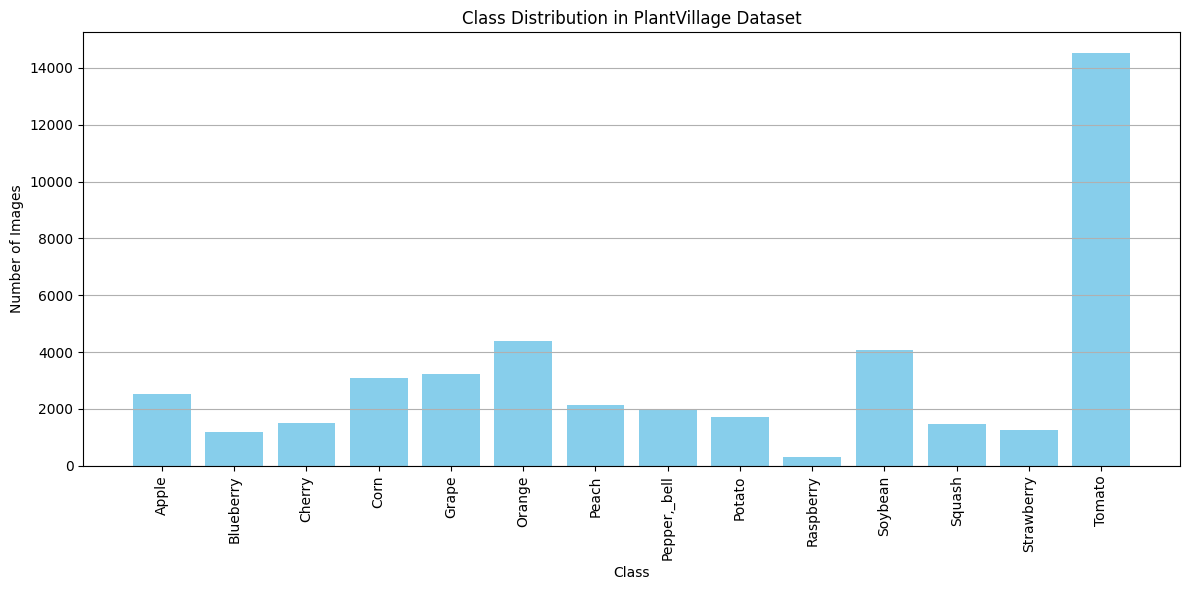

In [ ]:
# Visualize the class numbers distribution
if VERBOSE:
    counts_list = [counts[i] for i in range(len(split_labels))]

    plt.figure(figsize=(12, 6))
    plt.bar(split_labels, counts_list, color='skyblue')
    plt.xlabel('Family')
    plt.ylabel('Number of Images')
    plt.title('Classes Distribution')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
# Print element format
if VERBOSE:
    print("Element spec:", train_set.element_spec)
    
    # Example on a batch
    for batch in train_set.take(1):
        x, y = batch
        print("x shape:", x.shape, "  dtype:", x.dtype)
        print("y shape:", y.shape, "  dtype:", y.dtype)


Element spec: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))
x shape: (32, 128, 128, 3)   dtype: <dtype: 'float32'>
y shape: (32, 14)   dtype: <dtype: 'float32'>


In [67]:
model = model_train(num_classes)


c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │     1,835,022 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,840,302 (7.02 MB)

 Trainable params: 1,840,206 (7.02 MB)

 Non-trainable params: 96 (384.00 B)

In [68]:
# Model training - Saving best model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(checkpoint_file, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)


Epoch 1/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3329 - loss: 2.7222
Epoch 1: val_loss improved from inf to 2.68234, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3007s 2s/step - accuracy: 0.3329 - loss: 2.7222 - val_accuracy: 0.3345 - val_loss: 2.6823 - learning_rate: 0.0010
Epoch 2/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.3922 - loss: 2.0875
Epoch 2: val_loss improved from 2.68234 to 0.25430, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 836s 616ms/step - accuracy: 0.3922 - loss: 2.0869 - val_accuracy: 0.6860 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 3/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7258 - loss: 0.2114
Epoch 3: val_loss improved from 0.25430 to 0.18076, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 815s 600ms/step - accuracy: 0.7258 - loss: 0.2114 - val_accuracy: 0.7560 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 4/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.7699 - loss: 0.1735
Epoch 4: val_loss did not improve from 0.18076
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 761s 561ms/step - accuracy: 0.7699 - loss: 0.1735 - val_accuracy: 0.7709 - val_loss: 0.1879 - learning_rate: 0.0010
Epoch 5/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7922 - loss: 0.1676
Epoch 5: val_loss improved from 0.18076 to 0.17604, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 858s 631ms/step - accuracy: 0.7922 - loss: 0.1676 - val_accuracy: 0.7914 - val_loss: 0.1760 - learning_rate: 0.0010
Epoch 6/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8033 - loss: 0.1603
Epoch 6: val_loss did not improve from 0.17604
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 7885s 6s/step - accuracy: 0.8033 - loss: 0.1603 - val_accuracy: 0.7137 - val_loss: 0.2227 - learning_rate: 0.0010
Epoch 7/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.8119 - loss: 0.1587
Epoch 7: val_loss improved from 0.17604 to 0.16811, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 682s 502ms/step - accuracy: 0.8119 - loss: 0.1587 - val_accuracy: 0.8134 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 8/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8206 - loss: 0.1592
Epoch 8: val_loss did not improve from 0.16811
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 660s 486ms/step - accuracy: 0.8206 - loss: 0.1592 - val_accuracy: 0.8121 - val_loss: 0.1744 - learning_rate: 0.0010
Epoch 9/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.8278 - loss: 0.1577
Epoch 9: val_loss did not improve from 0.16811
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 680s 501ms/step - accuracy: 0.8278 - loss: 0.1577 - val_accuracy: 0.7980 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 10/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.8608 - loss: 0.1267
Epoch 10: val_loss improved from 0.16811 to 0.14449, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 786s 579ms/step - accuracy: 0.8608 - loss: 0.1267 - val_accuracy: 0.8043 - val_loss: 0.1445 - learning_rate: 5.0000e-04
Epoch 11/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8675 - loss: 0.1104
Epoch 11: val_loss improved from 0.14449 to 0.13562, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 778s 572ms/step - accuracy: 0.8675 - loss: 0.1104 - val_accuracy: 0.8401 - val_loss: 0.1356 - learning_rate: 5.0000e-04
Epoch 12/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8740 - loss: 0.1066
Epoch 12: val_loss did not improve from 0.13562
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 786s 579ms/step - accuracy: 0.8740 - loss: 0.1066 - val_accuracy: 0.8117 - val_loss: 0.1419 - learning_rate: 5.0000e-04
Epoch 13/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8770 - loss: 0.1058
Epoch 13: val_loss improved from 0.13562 to 0.12386, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 793s 584ms/step - accuracy: 0.8770 - loss: 0.1058 - val_accuracy: 0.8628 - val_loss: 0.1239 - learning_rate: 5.0000e-04
Epoch 14/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8796 - loss: 0.1044
Epoch 14: val_loss did not improve from 0.12386
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 786s 579ms/step - accuracy: 0.8796 - loss: 0.1044 - val_accuracy: 0.8224 - val_loss: 0.1385 - learning_rate: 5.0000e-04
Epoch 15/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.8897 - loss: 0.1006
Epoch 15: val_loss did not improve from 0.12386
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 755s 556ms/step - accuracy: 0.8897 - loss: 0.1006 - val_accuracy: 0.8311 - val_loss: 0.1399 - learning_rate: 5.0000e-04
Epoch 16/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9117 - loss: 0.0854
Epoch 16: val_loss improved from 0.12386 to 0.10935, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 802s 590ms/step - accuracy: 0.9118 - loss: 0.0854 - val_accuracy: 0.8529 - val_loss: 0.1094 - learning_rate: 2.5000e-04
Epoch 17/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9182 - loss: 0.0706
Epoch 17: val_loss did not improve from 0.10935
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 780s 574ms/step - accuracy: 0.9182 - loss: 0.0706 - val_accuracy: 0.8446 - val_loss: 0.1121 - learning_rate: 2.5000e-04
Epoch 18/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9213 - loss: 0.0676
Epoch 18: val_loss improved from 0.10935 to 0.10568, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 793s 584ms/step - accuracy: 0.9213 - loss: 0.0675 - val_accuracy: 0.8573 - val_loss: 0.1057 - learning_rate: 2.5000e-04
Epoch 19/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9241 - loss: 0.0656
Epoch 19: val_loss did not improve from 0.10568
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 787s 580ms/step - accuracy: 0.9241 - loss: 0.0656 - val_accuracy: 0.7513 - val_loss: 0.1617 - learning_rate: 2.5000e-04
Epoch 20/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9286 - loss: 0.0636
Epoch 20: val_loss did not improve from 0.10568
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 787s 579ms/step - accuracy: 0.9286 - loss: 0.0636 - val_accuracy: 0.8355 - val_loss: 0.1100 - learning_rate: 2.5000e-04
Epoch 21/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9446 - loss: 0.0554
Epoch 21: val_loss improved from 0.10568 to 0.09635, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 776s 571ms/step - accuracy: 0.9446 - loss: 0.0554 - val_accuracy: 0.8486 - val_loss: 0.0963 - learning_rate: 1.2500e-04
Epoch 22/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9503 - loss: 0.0467
Epoch 22: val_loss improved from 0.09635 to 0.08772, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 813s 580ms/step - accuracy: 0.9503 - loss: 0.0467 - val_accuracy: 0.8689 - val_loss: 0.0877 - learning_rate: 1.2500e-04
Epoch 23/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9505 - loss: 0.0436
Epoch 23: val_loss did not improve from 0.08772
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 807s 594ms/step - accuracy: 0.9505 - loss: 0.0436 - val_accuracy: 0.8551 - val_loss: 0.0890 - learning_rate: 1.2500e-04
Epoch 24/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9547 - loss: 0.0414
Epoch 24: val_loss did not improve from 0.08772
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 793s 584ms/step - accuracy: 0.9547 - loss: 0.0414 - val_accuracy: 0.8492 - val_loss: 0.0918 - learning_rate: 1.2500e-04
Epoch 25/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9644 - loss: 0.0369
Epoch 25: val_loss improved from 0.08772 to 0.07808, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 755s 556ms/step - accuracy: 0.9644 - loss: 0.0369 - val_accuracy: 0.8686 - val_loss: 0.0781 - learning_rate: 6.2500e-05
Epoch 26/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9680 - loss: 0.0332
Epoch 26: val_loss improved from 0.07808 to 0.07748, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 762s 561ms/step - accuracy: 0.9680 - loss: 0.0332 - val_accuracy: 0.8713 - val_loss: 0.0775 - learning_rate: 6.2500e-05
Epoch 27/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9688 - loss: 0.0320
Epoch 27: val_loss improved from 0.07748 to 0.06872, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 811s 597ms/step - accuracy: 0.9688 - loss: 0.0320 - val_accuracy: 0.8885 - val_loss: 0.0687 - learning_rate: 6.2500e-05
Epoch 28/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9725 - loss: 0.0295
Epoch 28: val_loss did not improve from 0.06872
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 848s 624ms/step - accuracy: 0.9725 - loss: 0.0295 - val_accuracy: 0.8767 - val_loss: 0.0738 - learning_rate: 6.2500e-05
Epoch 29/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9711 - loss: 0.0289
Epoch 29: val_loss improved from 0.06872 to 0.06673, saving model to best_model_14_families_focal.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 772s 569ms/step - accuracy: 0.9711 - loss: 0.0289 - val_accuracy: 0.8874 - val_loss: 0.0667 - learning_rate: 6.2500e-05
Epoch 30/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9690 - loss: 0.0287
Epoch 30: val_loss did not improve from 0.06673
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 800s 589ms/step - accuracy: 0.9690 - loss: 0.0287 - val_accuracy: 0.8732 - val_loss: 0.0709 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 29.


# CNN training history


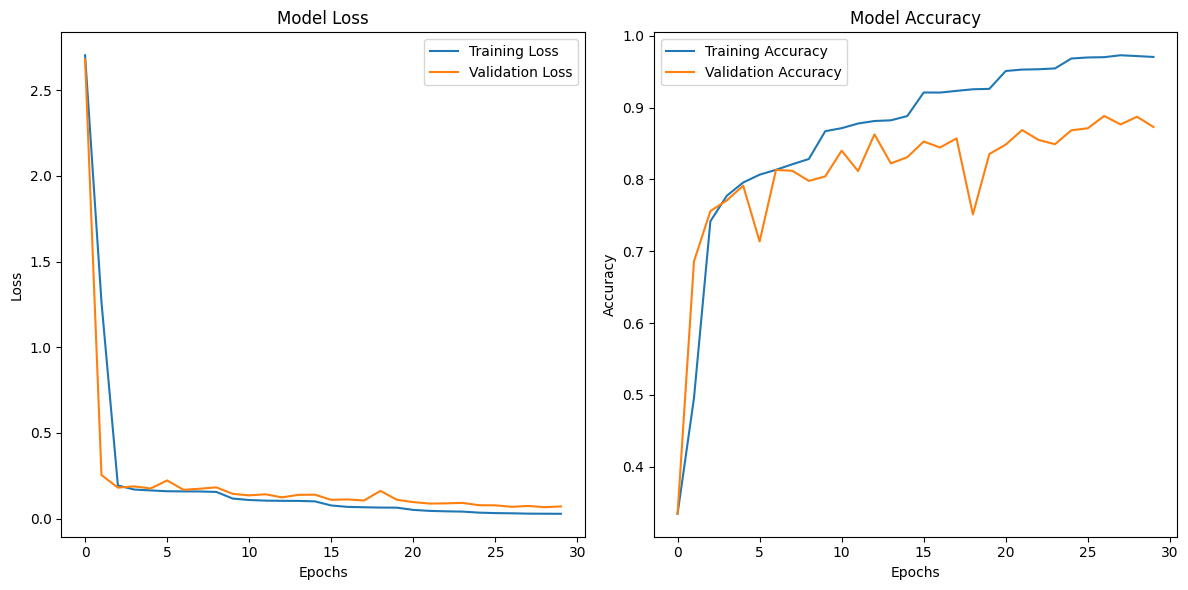

In [76]:
# plot training history (Loss and Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

In [ ]:
# Generate Predictions on Test Set
from tensorflow.keras import Sequential

#with keras.utils.custom_object_scope({'Sequential': Sequential}):
#model = keras.models.load_model('best_model_14_families.h5', compile=False)

y_true = [] # ground truth
y_pred = [] # prediction
y_score = [] # predictions vector
for images, labels in test_set:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

In [ ]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.888258
Precision: 0.901409
Recall: 0.888258
F1-score: 0.890904


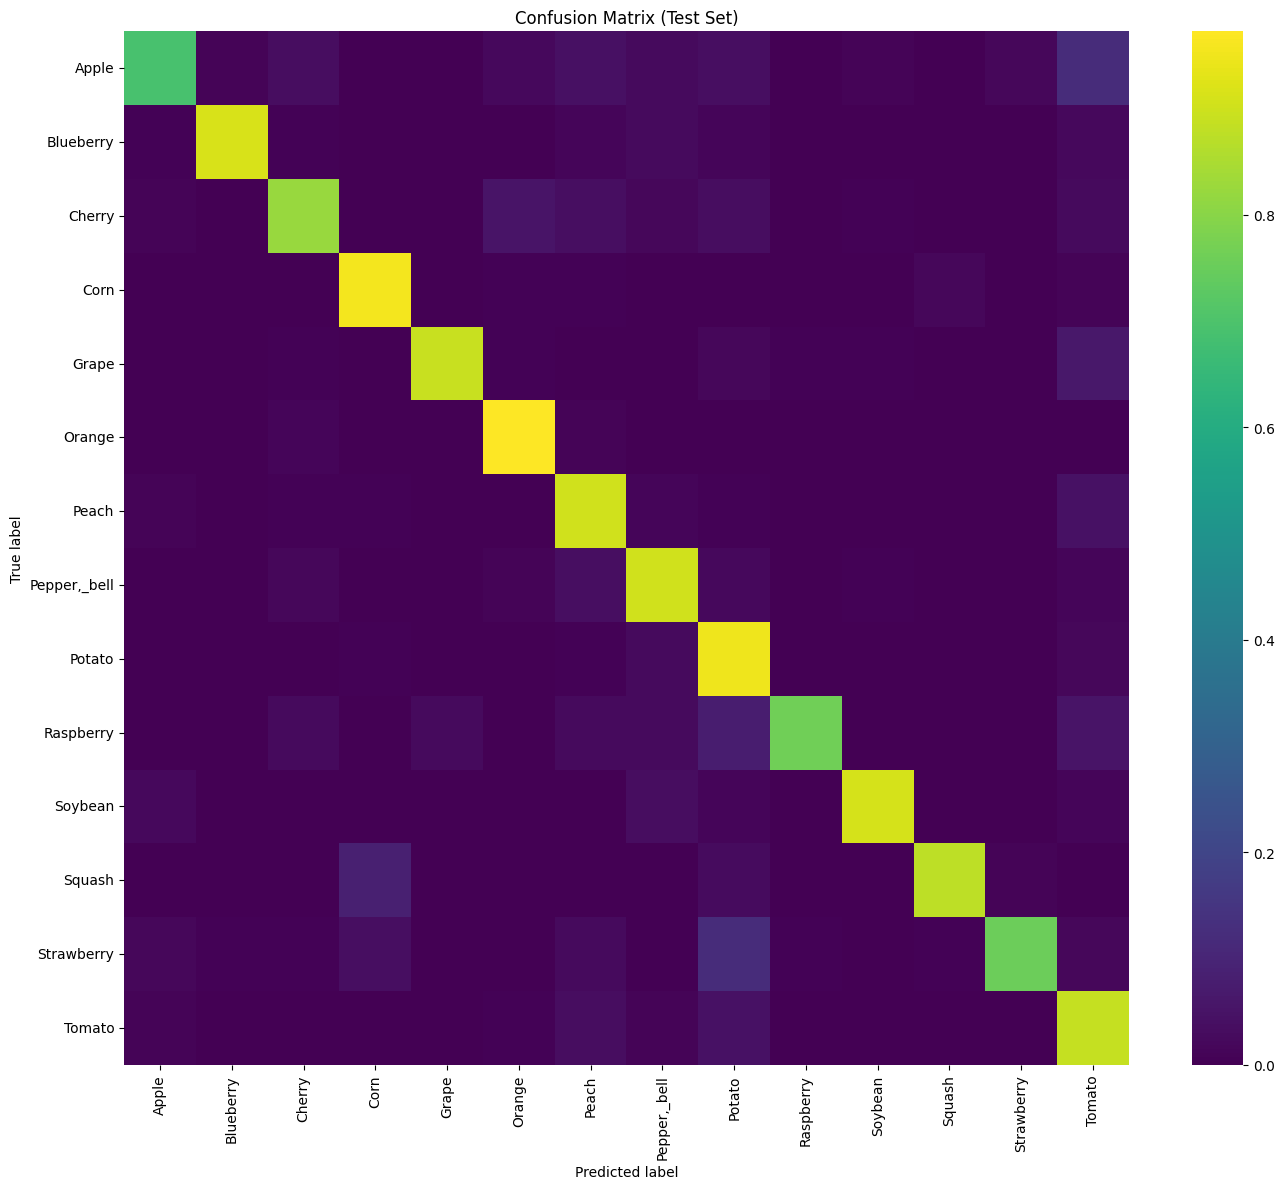

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

#Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis', xticklabels=split_labels, yticklabels=split_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


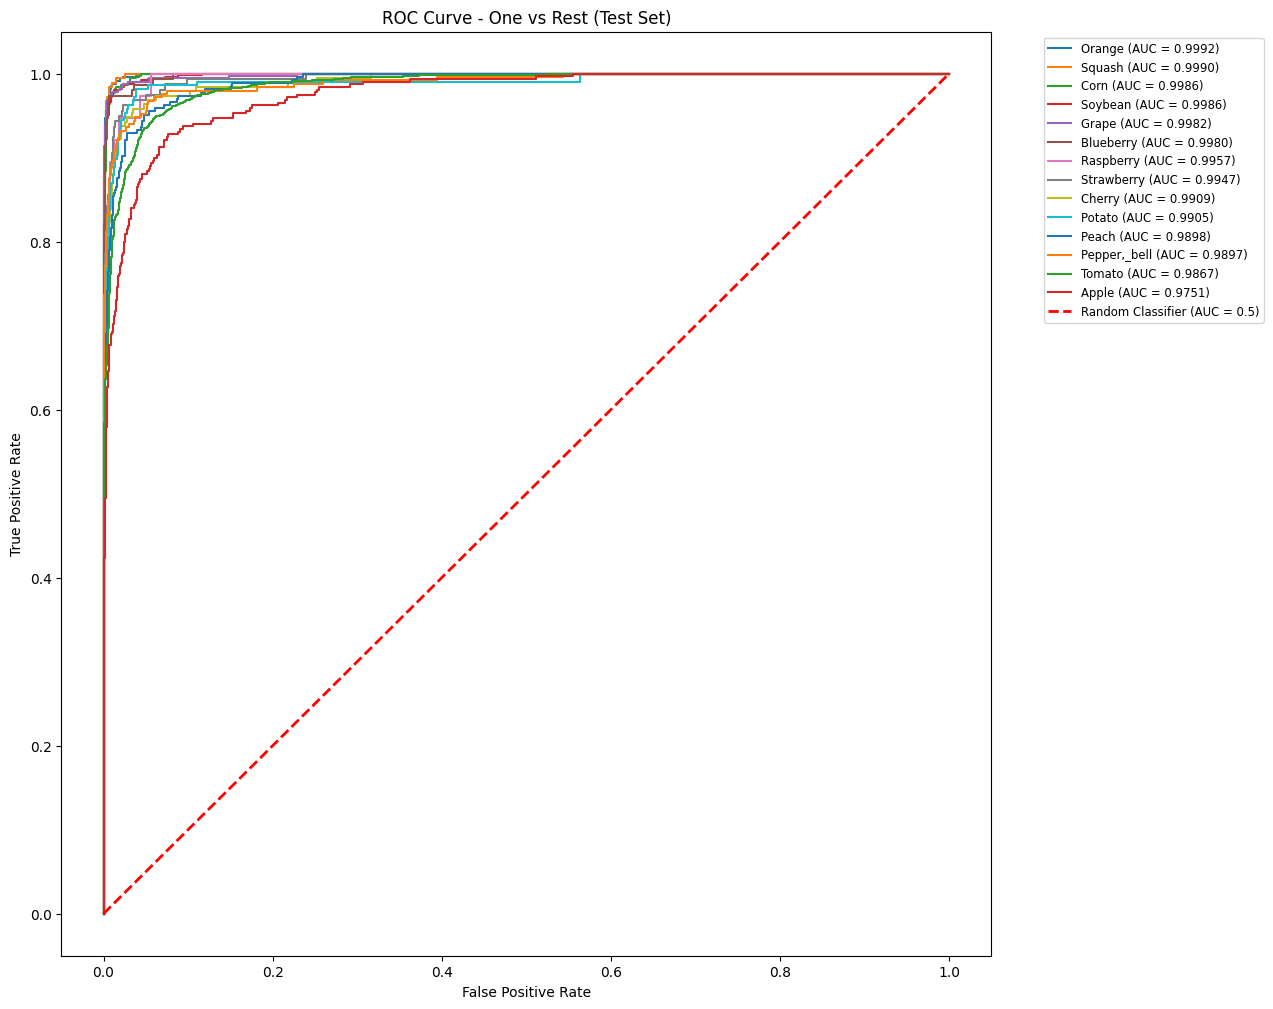

In [ ]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{split_labels[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')

plt.show()


In [81]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=split_labels)
print(report)


              precision    recall  f1-score   support

       Apple       0.84      0.69      0.76       319
   Blueberry       0.94      0.91      0.93       151
      Cherry       0.82      0.82      0.82       192
        Corn       0.93      0.96      0.94       388
       Grape       0.99      0.89      0.94       409
      Orange       0.94      0.97      0.96       552
       Peach       0.70      0.90      0.79       267
Pepper,_bell       0.79      0.90      0.84       250
      Potato       0.58      0.95      0.72       216
   Raspberry       0.76      0.76      0.76        38
     Soybean       0.98      0.91      0.94       509
      Squash       0.95      0.88      0.91       184
  Strawberry       0.91      0.75      0.82       159
      Tomato       0.94      0.89      0.91      1825

    accuracy                           0.89      5459
   macro avg       0.86      0.87      0.86      5459
weighted avg       0.90      0.89      0.89      5459

